# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
import sys
print(sys.version)


3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]


In [2]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes



config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,                      
    },
    'data': {
        'number_of_variables': 5, 
        'num_classes': 2,
        
        'function_generation_type': 'random_decision_tree', # 'make_classification' 'random_decision_tree'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 1000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [64],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [2048],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.2],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.01,
        'loss': 'binary_crossentropy',
        'metrics': ['binary_accuracy'],
        
        'epochs': 100, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 50, #Float for fraction, Int for number 0
        
        'function_representation_type': 3, # 1=standard representation; 2=sparse representation, 3=vanilla_dt

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500, 
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
        
    },    
    
    'computation':{
        'load_model': False,
        
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [3]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [4]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

#from prettytable import PrettyTable
#import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree



#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
#import tensorflow_addons as tfa
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 


import warnings

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [5]:
tf.__version__

'2.5.0'

In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/lib/cuda-10.1'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)

warnings.filterwarnings('ignore')

In [8]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = (2 ** maximum_depth - 1) * number_of_variables + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes
config['function_family']['function_representation_length'] = ( (2 ** maximum_depth - 1) * number_of_variables + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 
                                                              else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2
                                                              else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth))

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))
create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [9]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize1000_numLNets10000_var5_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/64_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense2048_drop0.2e100b256_adam
lNetSize1000_numLNets10000_var5_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/64_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [11]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    path_X_data = directory + 'X_test_lambda.txt'
    path_y_data = directory + 'y_test_lambda.txt'        
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    X_test_lambda = pd.read_csv(path_X_data, sep=",", header=None)
    X_test_lambda = X_test_lambda.sort_values(by=0)
    if no_noise == False:
        X_test_lambda = X_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    y_test_lambda = pd.read_csv(path_y_data, sep=",", header=None)
    y_test_lambda = y_test_lambda.sort_values(by=0)
    if no_noise == False:
        y_test_lambda = y_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              X_test_lambda_row, 
                                              y_test_lambda_row, 
                                              config) for network_parameters_row, X_test_lambda_row, y_test_lambda_row in zip(network_parameters.values, X_test_lambda.values, y_test_lambda.values))          
    del parallel
    
    base_model = generate_base_model(config)  
    
    def initialize_network_wrapper(config, lambda_net, base_model):
        lambda_net.initialize_network(config, base_model)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_network_wrapper)(config, lambda_net, base_model) for lambda_net in lambda_nets)   
    del parallel
    
    def initialize_target_function_wrapper(config, lambda_net):
        lambda_net.initialize_target_function(config)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_target_function_wrapper)(config, lambda_net) for lambda_net in lambda_nets)   
    del parallel
        
    
    #lambda_nets = [None] * network_parameters.shape[0]
    #for i, (network_parameters_row, X_test_lambda_row, y_test_lambda_row) in tqdm(enumerate(zip(network_parameters.values, X_test_lambda.values, y_test_lambda.values)), total=network_parameters.values.shape[0]):        
    #    lambda_net = LambdaNet(network_parameters_row, X_test_lambda_row, y_test_lambda_row, config)
    #    lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [12]:
#LOAD DATA
if noise_injected_level > 0:
    lambda_net_dataset_training = load_lambda_nets(config, no_noise=True, n_jobs=n_jobs)
    lambda_net_dataset_evaluation = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_training, test_split=0.1)
    _, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_evaluation, test_split=test_size)
    
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)

    

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-3)]: Done 1304 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-3)]: Done 9804 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-3)]: Done 10000 out of 10000 | elapsed:   17.1s finished
[Parallel(n_jobs=-3)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 10000 out of 10000 | elapsed:  3.6min finished
[Parallel(n_jobs=-3)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 10000 out of 10000 | elapsed:   24.0s finished


## Data Inspection

In [13]:
lambda_net_dataset_train.shape

(8955, 573)

In [14]:
lambda_net_dataset_valid.shape

(995, 573)

In [15]:
lambda_net_dataset_test.shape

(50, 573)

In [16]:
lambda_net_dataset_train.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f1v0,f1v1,f1v2,f1v3,f1v4,f2v0,f2v1,f2v2,f2v3,f2v4,f3v0,f3v1,f3v2,f3v3,f3v4,f4v0,f4v1,f4v2,f4v3,f4v4,f5v0,f5v1,f5v2,f5v3,f5v4,f6v0,f6v1,f6v2,f6v3,f6v4,f7v0,f7v1,f7v2,f7v3,f7v4,f8v0,f8v1,f8v2,f8v3,f8v4,f9v0,f9v1,f9v2,f9v3,f9v4,f10v0,f10v1,f10v2,f10v3,f10v4,f11v0,f11v1,f11v2,f11v3,f11v4,f12v0,f12v1,f12v2,f12v3,f12v4,f13v0,f13v1,f13v2,f13v3,f13v4,f14v0,f14v1,f14v2,f14v3,f14v4,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,...,wb_349,wb_350,wb_351,wb_352,wb_353,wb_354,wb_355,wb_356,wb_357,wb_358,wb_359,wb_360,wb_361,wb_362,wb_363,wb_364,wb_365,wb_366,wb_367,wb_368,wb_369,wb_370,wb_371,wb_372,wb_373,wb_374,wb_375,wb_376,wb_377,wb_378,wb_379,wb_380,wb_381,wb_382,wb_383,wb_384,wb_385,wb_386,wb_387,wb_388,wb_389,wb_390,wb_391,wb_392,wb_393,wb_394,wb_395,wb_396,wb_397,wb_398,wb_399,wb_400,wb_401,wb_402,wb_403,wb_404,wb_405,wb_406,wb_407,wb_408,wb_409,wb_410,wb_411,wb_412,wb_413,wb_414,wb_415,wb_416,wb_417,wb_418,wb_419,wb_420,wb_421,wb_422,wb_423,wb_424,wb_425,wb_426,wb_427,wb_428,wb_429,wb_430,wb_431,wb_432,wb_433,wb_434,wb_435,wb_436,wb_437,wb_438,wb_439,wb_440,wb_441,wb_442,wb_443,wb_444,wb_445,wb_446,wb_447,wb_448
6671,6671.000,42,0.343,0.000,0.000,0.000,0.000,0.269,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.273,0.000,0.000,0.000,0.000,0.330,0.000,0.000,0.411,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.307,0.291,0.000,0.000,0.000,0.000,0.000,0.331,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.316,0.000,0.000,0.000,0.332,0.000,0.000,0.000,0.000,0.350,0.000,0.000,0.000,0.000,0.000,0.360,0.000,0.000,-0.372,0.000,0.000,0.415,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.195,0.015,-0.105,-0.399,0.381,0.088,0.077,-0.194,-0.304,-0.072,-0.092,0.165,0.150,0.023,-0.369,-0.334,0.069,0.163,0.207,-0.017,0.049,-0.221,-0.077,-0.231,...,-0.186,-0.013,-0.074,-0.067,0.203,-0.048,-0.085,-0.005,-0.113,-0.060,0.000,0.342,-0.053,-0.151,-0.145,-0.066,-0.058,-0.105,0.081,-0.076,-0.094,-0.128,0.000,0.000,-0.018,0.006,-0.097,0.275,0.064,-0.034,-0.072,0.130,-0.083,-0.099,-0.142,-0.337,-0.649,0.130,-0.428,-1.037,0.031,0.121,0.214,-0.592,-0.272,0.194,-0.695,-0.563,-0.149,0.438,0.136,-0.906,-0.409,-0.319,-0.133,-0.573,-0.644,-0.628,-0.271,0.237,0.730,-0.196,0.108,-0.895,0.582,-0.350,0.167,0.214,0.478,-0.168,0.038,0.020,0.220,-0.054,-0.294,0.428,0.077,0.477,0.483,0.184,0.143,0.183,-1.227,0.092,-0.220,0.092,-0.187,-0.257,-0.146,-0.647,0.117,0.367,0.307,-0.259,0.160,-0.913,0.175,-0.025,0.208,0.081
3274,3274.000,42,0.000,0.000,0.000,0.000,0.372,0.000,0.000,0.365,0.000,0.000,0.226,0.000,0.000,0.000,0.000,0.000,0.000,-0.169,0.000,0.000,0.000,0.000,0.000,-0.366,0.000,0.000,0.000,-0.363,0.000,0.000,0.000,0.296,0.000,0.000,0.000,0.000,0.000,-0.297,0.000,0.000,0.000,0.191,0.000,0.000,0.000,0.000,0.000,0.000,0.433,0.000,0.000,0.000,0.000,0.000,0.410,0.000,-0.369,0.000,0.000,0.000,0.000,-0.440,0.000,0.000,0.000,0.000,0.371,0.000,0.000,0.000,0.000,0.000,0.000,-0.363,0.000,-0.317,0.115,0.268,0.390,-0.230,0.196,-0.281,-0.183,0.056,0.334,-0.403,0.193,0.080,0.308,0.126,-0.019,-0.241,0.170,0.182,0.005,-0.087,0.240,0.030,...,-0.142,-0.071,0.219,0.510,0.175,0.025,0.162,0.396,0.248,0.298,0.000,0.164,-0.056,0.061,-0.082,0.367,0.497,0.163,-0.052,0.250,0.056,0.138,0.000,0.000,0.063,-0.032,-0.079,0.006,0.008,-0.060,0.255,-0.048,0.315,-0.071,0.152,-0.103,0.567,0.500,-0.873,-0.209,0.738,1.438,-0.673,-0.720,-0.272,0.469,-0.870,-0.542,-0.154,0.036,1.268,0.849,-0.148,0.482,-0.135,-0.796,-0.597,0.603,0.572,0.536,0.639,-0.632,0.794,-0.741,-0.365,-0.661,0.751,1.597,0.536,-1.116,0.560,0.774,0.698,0.567,-0.294,0.314,0.070,0.136,0.110,0.900,1.551,0.653,-0.261,0.666,-0.787,0.116,-0.187,-0.257,-0.808,-0.604,0.069,0.500,-0.659,-0.510,0.830,-0.097,0.990,-0.162,0.603,0.124
3095,3095.000,42,0.000,0.000,0.000,0.295,0.000,0.000,-0.234,0.000,0.000,0.000,0.000,0.000,0.000,0.418,0.000,0.000,0.000,0.000,0.000,-0.394,0.000,0.000,0.000,0.345,0.000,0.000,0.000,0.000,0.000,0.421,0.000,0.421,0.000,0.000,0.000,-0.380,0.000,

In [17]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f1v0,f1v1,f1v2,f1v3,f1v4,f2v0,f2v1,f2v2,f2v3,f2v4,f3v0,f3v1,f3v2,f3v3,f3v4,f4v0,f4v1,f4v2,f4v3,f4v4,f5v0,f5v1,f5v2,f5v3,f5v4,f6v0,f6v1,f6v2,f6v3,f6v4,f7v0,f7v1,f7v2,f7v3,f7v4,f8v0,f8v1,f8v2,f8v3,f8v4,f9v0,f9v1,f9v2,f9v3,f9v4,f10v0,f10v1,f10v2,f10v3,f10v4,f11v0,f11v1,f11v2,f11v3,f11v4,f12v0,f12v1,f12v2,f12v3,f12v4,f13v0,f13v1,f13v2,f13v3,f13v4,f14v0,f14v1,f14v2,f14v3,f14v4,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,...,wb_349,wb_350,wb_351,wb_352,wb_353,wb_354,wb_355,wb_356,wb_357,wb_358,wb_359,wb_360,wb_361,wb_362,wb_363,wb_364,wb_365,wb_366,wb_367,wb_368,wb_369,wb_370,wb_371,wb_372,wb_373,wb_374,wb_375,wb_376,wb_377,wb_378,wb_379,wb_380,wb_381,wb_382,wb_383,wb_384,wb_385,wb_386,wb_387,wb_388,wb_389,wb_390,wb_391,wb_392,wb_393,wb_394,wb_395,wb_396,wb_397,wb_398,wb_399,wb_400,wb_401,wb_402,wb_403,wb_404,wb_405,wb_406,wb_407,wb_408,wb_409,wb_410,wb_411,wb_412,wb_413,wb_414,wb_415,wb_416,wb_417,wb_418,wb_419,wb_420,wb_421,wb_422,wb_423,wb_424,wb_425,wb_426,wb_427,wb_428,wb_429,wb_430,wb_431,wb_432,wb_433,wb_434,wb_435,wb_436,wb_437,wb_438,wb_439,wb_440,wb_441,wb_442,wb_443,wb_444,wb_445,wb_446,wb_447,wb_448
3466,3466.000,42,0.000,0.000,0.000,0.337,0.000,0.000,0.000,0.000,0.000,0.423,0.000,0.000,0.000,0.000,0.441,0.000,0.000,0.000,-0.408,0.000,0.000,0.000,0.000,0.413,0.000,0.000,0.000,-0.292,0.000,0.000,-0.362,0.000,0.000,0.000,0.000,0.397,0.000,0.000,0.000,0.000,0.000,0.000,0.425,0.000,0.000,0.435,0.000,0.000,0.000,0.000,0.000,0.000,0.382,0.000,0.000,0.000,-0.442,0.000,0.000,0.000,0.443,0.000,0.000,0.000,0.000,0.000,0.000,0.389,0.000,0.000,0.000,0.000,0.000,0.000,0.227,0.410,-0.065,0.297,0.409,-0.155,0.187,0.120,-0.277,0.149,0.041,0.190,-0.210,0.184,-0.093,-0.151,-0.250,0.081,0.229,-0.003,-0.162,-0.137,0.086,0.069,...,0.051,0.391,-0.290,0.095,-0.278,0.510,-0.466,-0.006,-0.243,-0.310,0.000,-0.471,-0.081,-0.231,-0.041,0.140,-0.033,-0.216,0.513,-0.304,0.415,-0.237,0.000,0.000,0.583,0.543,-0.018,-0.503,0.483,0.267,-0.239,0.358,0.089,0.559,-0.257,-0.337,-0.747,0.662,-1.313,-1.513,0.027,1.533,-0.593,-0.932,-0.272,0.520,-0.512,-0.399,-1.568,0.452,1.571,-1.192,-1.381,0.080,-1.350,-0.664,-0.984,-0.574,0.579,0.559,-1.041,-0.658,0.892,-1.215,-1.324,-0.590,0.767,1.274,0.533,-1.306,0.747,0.019,0.601,0.628,-0.294,0.547,1.393,0.512,0.943,1.488,1.629,0.776,-1.526,0.682,-0.744,0.423,-0.187,-0.257,-1.024,-1.258,0.684,0.651,-1.219,-0.268,1.183,-1.204,1.464,-1.440,0.629,-0.238
689,689.000,42,0.000,0.000,0.000,0.000,-0.413,-0.432,0.000,0.000,0.000,0.000,0.000,0.000,-0.288,0.000,0.000,0.000,0.433,0.000,0.000,0.000,-0.293,0.000,0.000,0.000,0.000,0.000,0.000,-0.331,0.000,0.000,0.000,0.000,0.000,-0.439,0.000,0.447,0.000,0.000,0.000,0.000,-0.363,0.000,0.000,0.000,0.000,0.000,0.000,-0.407,0.000,0.000,0.000,-0.423,0.000,0.000,0.000,0.000,-0.242,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.436,0.000,0.000,0.000,0.357,0.000,0.000,0.000,0.401,0.000,0.000,0.381,0.093,-0.380,0.171,-0.023,-0.239,0.030,-0.010,-0.136,-0.171,0.370,-0.312,-0.340,0.034,-0.386,-0.106,-0.086,-0.156,-0.069,-0.074,-0.215,0.120,0.192,...,0.313,0.004,-0.070,-0.075,-0.024,0.077,-0.072,0.000,-0.113,-0.070,0.000,0.068,0.257,0.022,0.074,-0.064,-0.042,-0.094,0.092,-0.079,-0.093,0.092,0.000,0.000,-0.007,0.035,0.179,-0.020,-0.014,0.012,-0.065,0.160,0.206,0.066,-0.130,-0.394,-0.452,0.323,-0.889,-0.836,0.031,0.125,0.161,-0.063,-0.272,0.238,-0.505,-0.359,-0.145,0.344,0.144,-0.822,-0.539,-0.237,-0.431,-0.234,-0.340,-0.440,-0.184,0.092,0.329,-0.226,0.099,-0.675,0.584,-0.337,0.168,0.217,0.125,-0.681,0.054,0.025,0.220,0.006,-0.294,0.151,0.679,0.355,0.512,0.204,0.157,0.185,-0.930,0.106,-0.238,0.353,-0.187,-0.257,-0.152,-0.504,0.589,0.038,-0.478,-0.320,0.164,-0.779,0.704,-0.636,0.208,-0.001
4148,4148.000,42,0.000,0.000,0.442,0.000,0.000,0.000,-0.344,0.000,0.000,0.000,0.000,-0.252,0.000,0.000,0.000,0.399,0.000,0.000,0.000,0.000,0.000,-0.345,0.000,0.000,0.000,0.398,0.000,0.000,0.000,0.000,0.000,0.000,-0.428,0.000,0.000

In [18]:
lambda_net_dataset_test.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f1v0,f1v1,f1v2,f1v3,f1v4,f2v0,f2v1,f2v2,f2v3,f2v4,f3v0,f3v1,f3v2,f3v3,f3v4,f4v0,f4v1,f4v2,f4v3,f4v4,f5v0,f5v1,f5v2,f5v3,f5v4,f6v0,f6v1,f6v2,f6v3,f6v4,f7v0,f7v1,f7v2,f7v3,f7v4,f8v0,f8v1,f8v2,f8v3,f8v4,f9v0,f9v1,f9v2,f9v3,f9v4,f10v0,f10v1,f10v2,f10v3,f10v4,f11v0,f11v1,f11v2,f11v3,f11v4,f12v0,f12v1,f12v2,f12v3,f12v4,f13v0,f13v1,f13v2,f13v3,f13v4,f14v0,f14v1,f14v2,f14v3,f14v4,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,...,wb_349,wb_350,wb_351,wb_352,wb_353,wb_354,wb_355,wb_356,wb_357,wb_358,wb_359,wb_360,wb_361,wb_362,wb_363,wb_364,wb_365,wb_366,wb_367,wb_368,wb_369,wb_370,wb_371,wb_372,wb_373,wb_374,wb_375,wb_376,wb_377,wb_378,wb_379,wb_380,wb_381,wb_382,wb_383,wb_384,wb_385,wb_386,wb_387,wb_388,wb_389,wb_390,wb_391,wb_392,wb_393,wb_394,wb_395,wb_396,wb_397,wb_398,wb_399,wb_400,wb_401,wb_402,wb_403,wb_404,wb_405,wb_406,wb_407,wb_408,wb_409,wb_410,wb_411,wb_412,wb_413,wb_414,wb_415,wb_416,wb_417,wb_418,wb_419,wb_420,wb_421,wb_422,wb_423,wb_424,wb_425,wb_426,wb_427,wb_428,wb_429,wb_430,wb_431,wb_432,wb_433,wb_434,wb_435,wb_436,wb_437,wb_438,wb_439,wb_440,wb_441,wb_442,wb_443,wb_444,wb_445,wb_446,wb_447,wb_448
7217,7217.000,42,-0.437,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.431,0.000,-0.291,0.000,0.000,0.000,0.000,0.000,0.000,-0.250,0.000,0.000,0.000,0.430,0.000,0.000,0.000,0.000,0.000,0.000,0.410,0.000,-0.411,0.000,0.000,0.000,0.000,0.446,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.255,0.223,0.000,0.000,0.000,0.000,0.000,0.000,0.325,0.000,0.000,0.000,0.000,0.444,0.000,0.000,0.000,-0.337,0.000,0.000,0.000,0.443,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.389,-0.065,0.393,-0.178,-0.007,-0.305,-0.298,0.252,0.291,-0.429,0.275,0.119,-0.112,0.321,-0.383,-0.231,-0.184,0.025,0.093,0.054,-0.007,-0.064,-0.003,-0.035,...,0.358,-0.423,-0.064,0.031,0.363,-0.081,0.527,0.000,0.457,0.567,0.000,0.346,-0.057,-0.100,-0.091,-0.012,0.173,0.311,-0.049,0.513,-0.291,0.312,0.000,0.000,0.000,-0.408,-0.122,0.465,-0.379,-0.283,-0.047,0.221,-0.084,-0.084,0.294,-0.821,0.733,0.344,-1.460,-0.210,0.891,1.166,-0.724,-0.831,-0.272,0.153,-1.152,-0.689,-0.148,0.083,0.774,1.012,-0.144,0.518,-0.938,-1.488,-0.682,0.715,0.537,0.420,0.885,-0.829,0.960,-1.367,0.460,-0.942,0.174,0.425,0.349,-1.436,0.688,0.025,0.618,0.688,-0.294,0.191,0.078,0.156,0.148,0.221,0.848,0.379,-0.262,0.727,-0.833,0.253,-0.187,-0.257,-0.159,-0.837,0.120,0.453,-0.839,-0.436,0.201,-1.399,0.177,-0.155,0.355,0.278
8291,8291.000,42,0.000,0.000,-0.391,0.000,0.000,0.000,0.000,0.000,0.419,0.000,-0.389,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.290,0.000,0.000,0.000,0.000,0.443,0.000,0.000,0.000,0.000,-0.257,0.000,0.000,0.000,-0.430,0.000,0.000,0.000,-0.418,0.000,0.000,-0.224,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.424,0.000,0.000,-0.343,0.000,0.000,0.000,0.000,0.000,0.294,0.000,0.000,0.408,0.000,0.000,0.000,0.000,0.000,0.000,-0.326,0.000,0.000,0.324,0.000,0.000,0.000,0.418,0.086,-0.061,0.131,0.193,0.094,0.142,0.232,0.158,-0.350,0.075,-0.410,0.028,-0.125,-0.023,-0.213,0.242,0.087,-0.014,0.150,-0.173,-0.107,-0.075,...,0.380,-0.122,0.308,0.367,0.252,-0.024,-0.025,-0.010,-0.124,0.365,0.000,-0.203,0.360,0.312,0.312,-0.065,0.411,0.234,-0.038,0.322,-0.047,-0.097,0.000,0.000,0.000,-0.047,-0.106,-0.185,-0.075,-0.093,0.351,-0.048,0.378,-0.041,0.158,-0.154,-0.461,0.079,-0.261,-0.216,0.030,0.842,-0.649,-0.707,-0.272,0.195,-0.659,-0.489,-0.145,0.479,0.874,0.698,-0.630,-0.370,-0.117,-0.774,-0.595,-0.482,-0.003,0.169,0.003,-0.101,0.878,-0.207,0.612,-0.586,0.775,0.907,0.589,-0.092,0.062,0.017,0.216,0.635,-0.294,-0.266,0.711,0.714,0.729,0.207,0.913,0.710,-0.272,0.686,-0.550,0.102,-0.187,-0.257,-0.159,-0.007,0.150,-0.214,-0.121,-0.616,0.869,-0.122,0.849,-0.662,0.549,0.071
4607,4607.000,42,0.000,0.304,0.000,0.000,0.000,0.000,0.000,-0.418,0.000,0.000,0.000,0.000,-0.406,0.000,0.000,0.000,-0.419,0.000,0.000,0.000,0.438,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.443,0.000,0.000,-0.412,0.000,0.000,0.00

## Interpretation Network Training

In [19]:
#%load_ext autoreload

In [20]:
#%autoreload 2
((X_valid, y_valid), 
 (X_test, y_test),
 history,

 model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=['plot_losses']
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/100
35/35 [==============================] - 30s 536ms/step - loss: 0.6062 - binary_accuracy_inet_decision_function_fv_metric: 0.6655 - val_loss: 0.5400 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7245
Epoch 2/100
35/35 [==============================] - 11s 302ms/step - loss: 0.5517 - binary_accuracy_inet_decision_function_fv_metric: 0.7140 - val_loss: 0.5225 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7355
Epoch 3/100
35/35 [==============================] - 13s 386ms/step - loss: 0.5413 - binary_accuracy_inet_decision_function_fv_metric: 0.7219 - val_loss: 0.5139 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7453
Epoch 4/100
35/35 [==============================] - 13s 360ms/step - loss: 0.5430 - binary_accuracy_inet_decision_function_fv_metric: 0.7188 - val_loss: 0.5181 - val_binary_accuracy_inet_decision_functio

<Figure size 432x288 with 0 Axes>

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 449)]        0                                            
__________________________________________________________________________________________________
hidden1_2048 (Dense)            (None, 2048)         921600      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 2048)         0           hidden1_2048[0][0]               
__________________________________________________________________________________________________
dropout1_0.2 (Dropout)          (None, 2048)         0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [22]:
def generate_random_data_points_custom(low, high, size, variables, distrib='uniform'):
    if distrib=='normal':
        list_of_data_points = []
        for _ in range(size):
            random_data_points = np.random.normal(loc=(low+high)/2, scale=(low+high)/4, size=variables)
            while max(random_data_points) > high and min(random_data_points) < low:
                random_poly = np.random.normal(loc=(low+high)/2, scale=1.0, size= variables)
            list_of_data_points.append(random_poly)
        list_of_data_points = np.array(list_of_polynomials)
        
    elif distrib=='uniform':
        list_of_data_points = np.random.uniform(low=low, high=high, size=(size, variables))
        
    return list_of_data_points

In [23]:
y_test_inet_vanilla_dt_list = []
y_test_distilled_sklearn_vanilla_dt_list = []

binary_crossentropy_distilled_sklearn_vanilla_dt_list =[]
accuracy_distilled_sklearn_vanilla_dt_list = []
f1_score_distilled_sklearn_vanilla_dt_list = []

binary_crossentropy_inet_vanilla_dt_list =[]
accuracy_inet_vanilla_dt_list = []
f1_score_inet_vanilla_dt_list = []

number = 10

for lambda_net_parameters, lambda_net, X_test_lambda, y_test_lambda in tqdm(zip(lambda_net_dataset_train.network_parameters_array[:number], lambda_net_dataset_train.network_list[:number], lambda_net_dataset_train.X_test_lambda_array[:number], lambda_net_dataset_train.y_test_lambda_array[:number]), total=lambda_net_dataset_train.y_test_lambda_array[:number].shape[0]):
    dt_inet = model.predict(np.array([lambda_net_parameters]))[0]
    
    X_data_random = generate_random_data_points_custom(0, 1, 5000, 5)
    y_data_random_lambda_pred = lambda_net.predict(X_data_random)
    y_data_random_lambda_pred = np.round(y_data_random_lambda_pred).astype(np.int64)
    
    dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
    dt_sklearn_distilled.fit(X_data_random, y_data_random_lambda_pred)
    
    y_test_inet_vanilla_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()
    y_test_distilled_sklearn_vanilla_dt = dt_sklearn_distilled.predict(X_test_lambda)
    
    y_test_inet_vanilla_dt_list.append(y_test_inet_vanilla_dt)
    y_test_distilled_sklearn_vanilla_dt_list.append(y_test_distilled_sklearn_vanilla_dt)
    
    y_test_lambda_pred = lambda_net.predict(X_test_lambda)
    y_test_lambda_pred = np.round(y_test_lambda_pred)
    
    binary_crossentropy_distilled_sklearn_vanilla_dt = log_loss(y_test_lambda_pred, y_test_distilled_sklearn_vanilla_dt)
    accuracy_distilled_sklearn_vanilla_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_vanilla_dt))
    f1_score_distilled_sklearn_vanilla_dt = f1_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_vanilla_dt))
    
    binary_crossentropy_inet_vanilla_dt = log_loss(y_test_lambda_pred, y_test_inet_vanilla_dt)
    accuracy_inet_vanilla_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_inet_vanilla_dt))
    f1_score_inet_vanilla_dt = f1_score(y_test_lambda_pred, np.round(y_test_inet_vanilla_dt))

    binary_crossentropy_distilled_sklearn_vanilla_dt_list.append(np.nan_to_num(binary_crossentropy_distilled_sklearn_vanilla_dt))
    accuracy_distilled_sklearn_vanilla_dt_list.append(np.nan_to_num(accuracy_distilled_sklearn_vanilla_dt))
    f1_score_distilled_sklearn_vanilla_dt_list.append(np.nan_to_num(f1_score_distilled_sklearn_vanilla_dt))

    binary_crossentropy_inet_vanilla_dt_list.append(np.nan_to_num(binary_crossentropy_inet_vanilla_dt))
    accuracy_inet_vanilla_dt_list.append(np.nan_to_num(accuracy_inet_vanilla_dt))
    f1_score_inet_vanilla_dt_list.append(np.nan_to_num(f1_score_inet_vanilla_dt))
    
    
print('Binary Crossentropy:\t\t', np.round(np.mean(binary_crossentropy_distilled_sklearn_vanilla_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(binary_crossentropy_inet_vanilla_dt_list), 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(np.mean(accuracy_distilled_sklearn_vanilla_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(accuracy_inet_vanilla_dt_list), 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(np.mean(f1_score_distilled_sklearn_vanilla_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(f1_score_inet_vanilla_dt_list), 3), '(I-Net DT)')
      

  0%|          | 0/10 [00:00<?, ?it/s]

Binary Crossentropy:		 2.28 (Sklearn DT) 	 0.405 (I-Net DT)
Accuracy:		 0.934 (Sklearn DT) 	 0.803 (I-Net DT)
F1 Score:		 0.925 (Sklearn DT) 	 0.788 (I-Net DT)


In [24]:
splits, leaf_classes = get_shaped_parameters_for_decision_tree(dt_inet, config)
print(splits)
print(leaf_classes)

tf.Tensor(
[[0.40411717 0.         0.         0.         0.        ]
 [0.         0.43671343 0.         0.         0.        ]
 [0.         0.         0.         0.         0.7356473 ]
 [0.48050976 0.         0.         0.         0.        ]
 [0.         0.         0.5614599  0.         0.        ]
 [0.5396898  0.         0.         0.         0.        ]
 [0.4499029  0.         0.         0.         0.        ]
 [0.         0.         0.         0.4395008  0.        ]
 [0.         0.         0.         0.42415333 0.        ]
 [0.         0.         0.         0.6184182  0.        ]
 [0.         0.509995   0.         0.         0.        ]
 [0.57767594 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.5474168 ]
 [0.         0.55780524 0.         0.         0.        ]
 [0.         0.48925564 0.         0.         0.        ]], shape=(15, 5), dtype=float32)
tf.Tensor(
[0.995335   0.99810034 0.94484526 0.93583965 0.886309   0.9000915
 0.9641106

In [25]:
calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()[:20]

array([0.11554039, 0.11554039, 0.41159153, 0.08976948, 0.11554039,
       0.5451133 , 0.11554039, 0.11554039, 0.5451133 , 0.08976948,
       0.5451133 , 0.11554039, 0.00189966, 0.00466502, 0.5451133 ,
       0.09990847, 0.5451133 , 0.11554039, 0.11554039, 0.08976948],
      dtype=float32)

In [26]:
new_tree = dt_array_to_sklearn(dt_inet, config, X_test_lambda, y_test_lambda, printing=False)
new_tree.predict(X_test_lambda)[:20]

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0.])

In [27]:
lambda_net.predict(X_test_lambda).ravel()

array([0.00087267, 0.23340604, 0.9964906 , ..., 0.06551006, 0.00368723,
       0.09750965], dtype=float32)

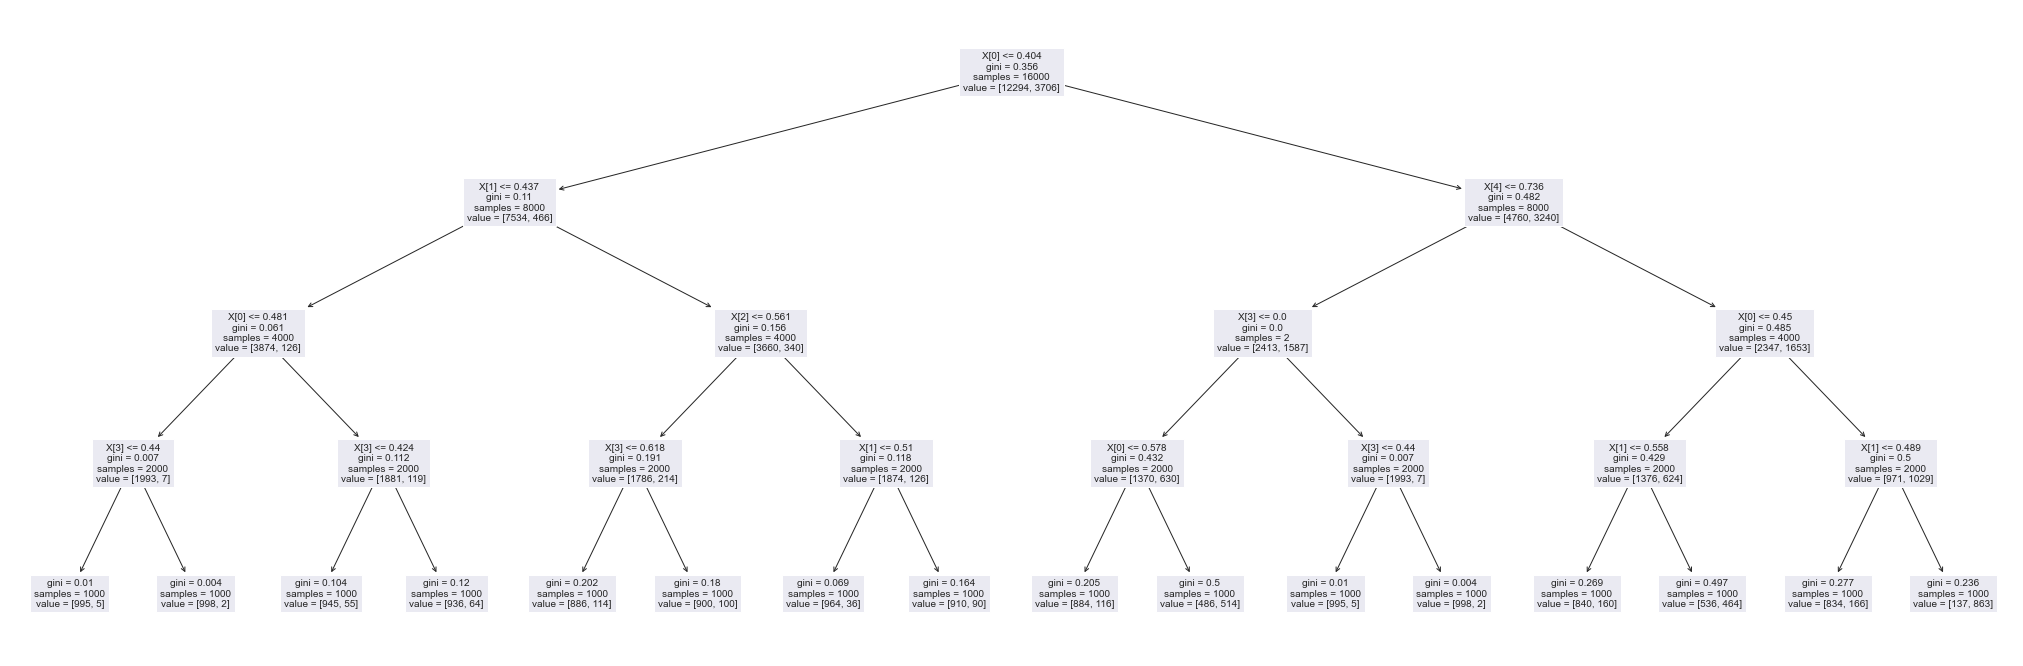

In [28]:
plt.figure(figsize=(36,12))  # set plot size (denoted in inches)
plot_tree(new_tree, fontsize=10)
plt.show()

In [1]:
y_test_inet_vanilla_dt_list = []
y_test_distilled_sklearn_vanilla_dt_list = []

binary_crossentropy_distilled_sklearn_vanilla_dt_list =[]
accuracy_distilled_sklearn_vanilla_dt_list = []
f1_score_distilled_sklearn_vanilla_dt_list = []

binary_crossentropy_inet_vanilla_dt_list =[]
accuracy_inet_vanilla_dt_list = []
f1_score_inet_vanilla_dt_list = []

for lambda_net_parameters, lambda_net, X_test_lambda, y_test_lambda in tqdm(zip(lambda_net_dataset_test.network_parameters_array, lambda_net_dataset_test.network_list, lambda_net_dataset_test.X_test_lambda_array, lambda_net_dataset_test.y_test_lambda_array), total=lambda_net_dataset_test.y_test_lambda_array.shape[0]):
    dt_inet = model.predict(np.array([lambda_net_parameters]))[0]
    
    X_data_random = generate_random_data_points_custom(0, 1, 5000, 5)
    y_data_random_lambda_pred = lambda_net.predict(X_data_random)
    y_data_random_lambda_pred = np.round(y_data_random_lambda_pred).astype(np.int64)
    
    dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
    dt_sklearn_distilled.fit(X_data_random, y_data_random_lambda_pred)
    
    y_test_inet_vanilla_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()
    y_test_distilled_sklearn_vanilla_dt = dt_sklearn_distilled.predict(X_test_lambda)
    
    y_test_inet_vanilla_dt_list.append(y_test_inet_vanilla_dt)
    y_test_distilled_sklearn_vanilla_dt_list.append(y_test_distilled_sklearn_vanilla_dt)
    
    y_test_lambda_pred = lambda_net.predict(X_test_lambda)
    y_test_lambda_pred = np.round(y_test_lambda_pred)
    
    binary_crossentropy_distilled_sklearn_vanilla_dt = log_loss(y_test_lambda_pred, y_test_distilled_sklearn_vanilla_dt)
    accuracy_distilled_sklearn_vanilla_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_vanilla_dt))
    f1_score_distilled_sklearn_vanilla_dt = f1_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_vanilla_dt))
    
    binary_crossentropy_inet_vanilla_dt = log_loss(y_test_lambda_pred, y_test_inet_vanilla_dt)
    accuracy_inet_vanilla_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_inet_vanilla_dt))
    f1_score_inet_vanilla_dt = f1_score(y_test_lambda_pred, np.round(y_test_inet_vanilla_dt))

    binary_crossentropy_distilled_sklearn_vanilla_dt_list.append(np.nan_to_num(binary_crossentropy_distilled_sklearn_vanilla_dt))
    accuracy_distilled_sklearn_vanilla_dt_list.append(np.nan_to_num(accuracy_distilled_sklearn_vanilla_dt))
    f1_score_distilled_sklearn_vanilla_dt_list.append(np.nan_to_num(f1_score_distilled_sklearn_vanilla_dt))

    binary_crossentropy_inet_vanilla_dt_list.append(np.nan_to_num(binary_crossentropy_inet_vanilla_dt))
    accuracy_inet_vanilla_dt_list.append(np.nan_to_num(accuracy_inet_vanilla_dt))
    f1_score_inet_vanilla_dt_list.append(np.nan_to_num(f1_score_inet_vanilla_dt))
    
    
print('Binary Crossentropy:\t\t', np.round(np.mean(binary_crossentropy_distilled_sklearn_vanilla_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(binary_crossentropy_inet_vanilla_dt_list), 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(np.mean(accuracy_distilled_sklearn_vanilla_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(accuracy_inet_vanilla_dt_list), 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(np.mean(f1_score_distilled_sklearn_vanilla_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(f1_score_inet_vanilla_dt_list), 3), '(I-Net DT)')
      

NameError: name 'tqdm' is not defined

In [ ]:
y_test_inet_vanilla_dt_list[0].numpy()[:20]


In [ ]:
y_test_distilled_sklearn_vanilla_dt_list[0][:20]

In [ ]:
lambda_net = np.array([lambda_net_dataset_test.network_parameters_array[0]])
X_data_lambda = lambda_net_dataset_test.X_test_lambda_array[2]
y_data_lambda = lambda_net_dataset_test.y_test_lambda_array[0]
print(lambda_net.shape)
dt_pred = model.predict(lambda_net)[0]
print(dt_pred)

In [ ]:
splits, leaf_classes = get_shaped_parameters_for_decision_tree(dt_pred, config)
print(splits)
print(leaf_classes)

In [ ]:
#new_tree = dt_array_to_sklearn(dt_pred, config, printing=True)
new_tree = dt_array_to_sklearn(dt_pred, config, X_data_lambda, y_data_lambda, printing=False)


In [ ]:
print(splits)
print(leaf_classes)

In [ ]:
direct_pred = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_data_lambda[:50], config)(dt_pred)
print(direct_pred)
print(np.round(direct_pred))

In [ ]:
new_tree.predict(X_data_lambda[:50])

In [ ]:
y_data_lambda[:50].ravel()

In [ ]:
plt.figure(figsize=(36,12))  # set plot size (denoted in inches)
plot_tree(new_tree, fontsize=10)
plt.show()

In [ ]:
X_data_lambda[:50]

In [ ]:
new_tree.predict(X_data_lambda[:50])

In [ ]:
z

In [ ]:
max_depth = 3
indices_list = [i for i in range(2**(max_depth+1)-1)]
print('indices_list', indices_list)
pre_order_from_level = np.array(level_to_pre(indices_list, 0, []))
print('pre_order_from_level', pre_order_from_level)
leaf_indices_pre_order = np.argwhere(pre_order_from_level>=2**max_depth-1).ravel()
print(leaf_indices_pre_order)
left_indices_pre_order = np.argwhere(pre_order_from_level % 2 != 0).ravel()
right_indices_pre_order = np.argwhere(pre_order_from_level % 2 == 0).ravel()[1:]
print('left_indices_pre_order', left_indices_pre_order)
print('right_indices_pre_order', right_indices_pre_order)

counter = 0
order = []
children_left = []
children_right = []
for i in range(2**(max_depth+1)-1):
    if i in leaf_indices_pre_order:
        order.append(-1)
        if i in left_indices_pre_order:
            children_left.append(-1)
        if i in right_indices_pre_order:
            children_right.append(-1)        
        continue
    else:
        order.append(counter)
        if i in left_indices_pre_order:
            children_left.append(counter)
        if i in right_indices_pre_order:
            children_right.append(counter)           
        counter += 1
order = np.array(order)
children_left = np.array(children_left)
children_right = np.array(children_right)

print('order', order)
print('children_left', children_left)
print('children_right', children_right)


In [ ]:
model.summary()

In [ ]:
acc_target_lambda_list = []
bc_target_lambda_list = []

acc_lambda_decision_list = []
bc_lambda_decision_list = []

acc_target_decision_list = []
bc_target_decision_list = []

decision_function_parameters_list = []
decision_functio_list = []

for lambda_net in tqdm(lambda_net_dataset_test.lambda_net_list):
    
    target_function_parameters = lambda_net.target_function_parameters
    target_function = lambda_net.target_function
    
    X_test_lambda = lambda_net.X_test_lambda
    y_test_lambda = lambda_net.y_test_lambda
    
    network = lambda_net.network
    network_parameters = lambda_net.network_parameters
    
    if config['i_net']['convolution_layers'] != None or config['i_net']['lstm_layers'] != None or (config['i_net']['nas'] and config['nas_type']['convolution_layers'] != 'SEQUENTIAL'):
        network_parameters, network_parameters_flat = restructure_data_cnn_lstm(np.array([network_parameters]), config, subsequences=None)    
      
    decision_function_parameters= model.predict(np.array([network_parameters]))[0]
    decision_function = generate_decision_tree_from_array(decision_function_parameters, config)
    
    decision_function_parameters_list.append(decision_function_parameters)
    decision_functio_list.append(decision_function)
    
    y_test_network = network.predict(X_test_lambda)
    y_test_decision_function = decision_function.predict_proba(X_test_lambda)
    y_test_target_function = target_function.predict_proba(X_test_lambda)  
    
    acc_target_lambda = accuracy_score(np.round(y_test_target_function), np.round(y_test_network))
    bc_target_lambda = log_loss(np.round(y_test_target_function), y_test_network, labels=[0, 1])
    
    acc_lambda_decision = accuracy_score(np.round(y_test_network), np.round(y_test_decision_function))
    bc_lambda_decision = log_loss(np.round(y_test_network), y_test_decision_function, labels=[0, 1])        
    
    acc_target_decision = accuracy_score(np.round(y_test_target_function), np.round(y_test_decision_function))
    bc_target_decision = log_loss(np.round(y_test_target_function), y_test_decision_function, labels=[0, 1])   
    
    
    acc_target_lambda_list.append(acc_target_lambda)
    bc_target_lambda_list.append(bc_target_lambda)

    acc_lambda_decision_list.append(acc_lambda_decision)
    bc_lambda_decision_list.append(bc_lambda_decision)

    acc_target_decision_list.append(acc_target_decision)
    bc_target_decision_list.append(bc_target_decision)
    

acc_target_lambda_array = np.array(acc_target_lambda_list)
bc_target_lambda_array = np.array(bc_target_lambda_list)

acc_lambda_decision_array = np.array(acc_lambda_decision_list)
bc_lambda_decision_array = np.array(bc_lambda_decision_list)

acc_target_decision_array = np.array(acc_target_decision_list)
bc_target_decision_array = np.array(bc_target_decision_list)
    
    
acc_target_lambda = np.mean(acc_target_lambda_array)
bc_target_lambda = np.mean(bc_target_lambda_array[~np.isnan(bc_target_lambda_array)])

acc_lambda_decision = np.mean(acc_lambda_decision_array)
bc_lambda_decision = np.mean(bc_lambda_decision_array[~np.isnan(bc_lambda_decision_array)])

acc_target_decision = np.mean(acc_target_decision_array)
bc_target_decision = np.mean(bc_target_decision_array[~np.isnan(bc_target_decision_array)])


print('Accuracy Target Lambda', acc_target_lambda)
print('Binary Crossentropy Target Lambda', bc_target_lambda)
print('Accuracy Lambda Decision', acc_lambda_decision)
print('Binary Crossentropy Lambda Decision', bc_lambda_decision)
print('Accuracy Target Decision', acc_target_decision)
print('Binary Crossentropy Target Decision', bc_target_decision)


In [ ]:
X_test_lambda

In [ ]:
np.round(y_test_network).ravel()[:100]

In [ ]:
np.round(y_test_decision_function).ravel()[:100]

In [ ]:
acc_lambda_decision_array

In [ ]:
# TODO BENCHMARK RANDOM GUESS